The late afternoon wind speeds (between 15 and 18 LMST) seem to have an issue. Moderate wind speeds (between about 5 and 7 m/s) are dropped somehow, and only smaller or larger wind speeds are recorded. Unfortunately, for my wind profile experiments, this gap in the data is basically fatal. So instead of trying to use the data directly, I'm going to try to replicate the red noise structure and generate synthetic data. This notebook attempts to do that analysis.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from local_utils import *

Processing label: ./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE


Text(0, 0.5, '$U\\ \\left( {\\rm cm\\ s^{-1}} \\right)$')

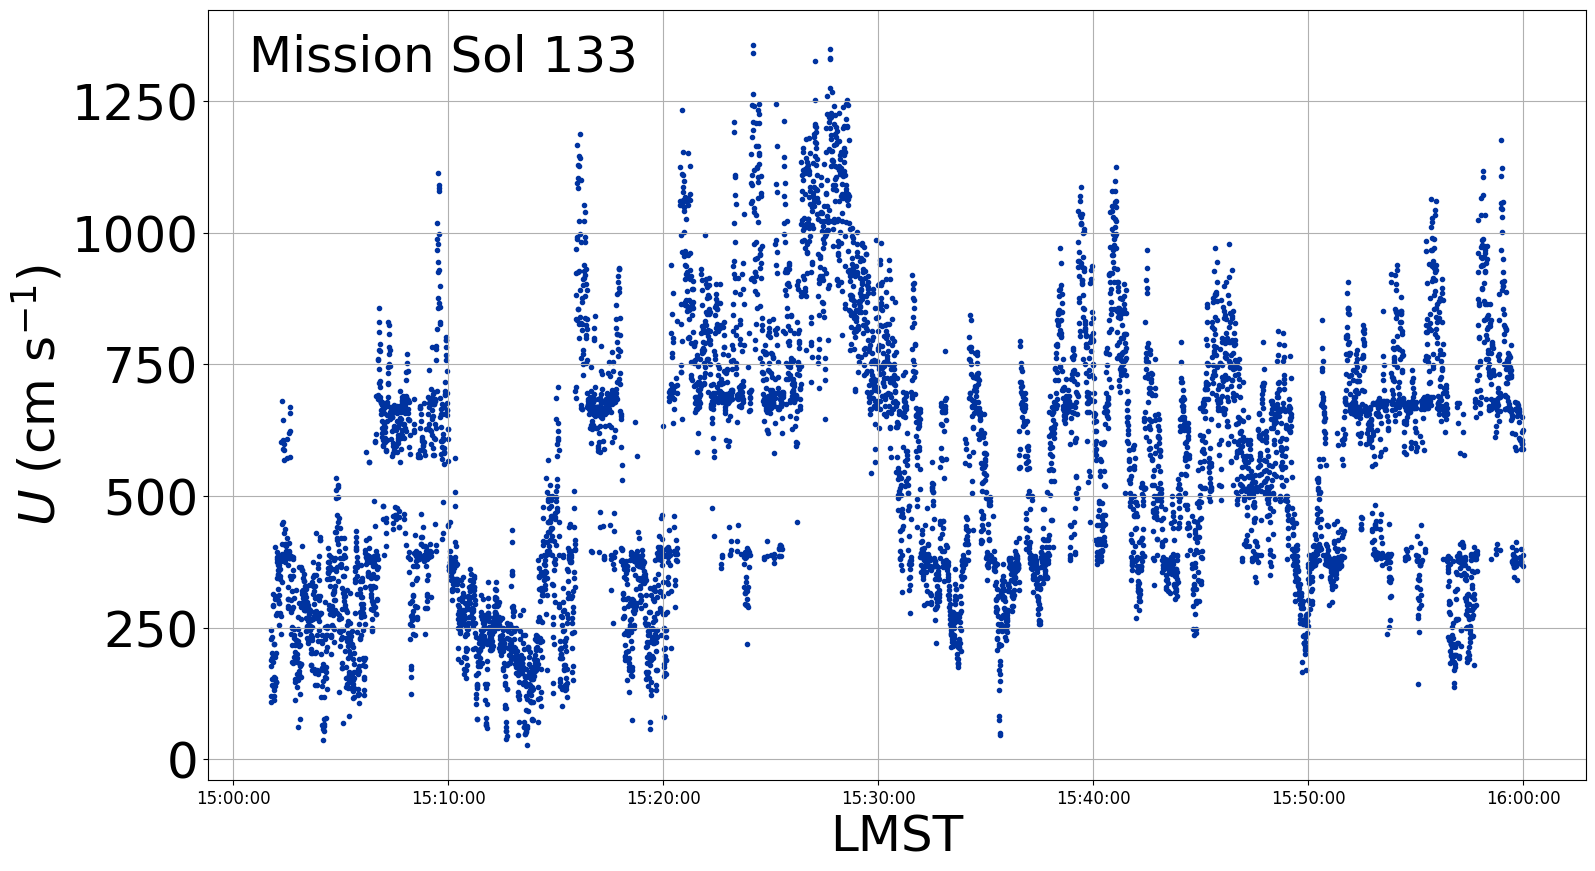

In [2]:
# WS_file = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/WE__0133___________DER_WS__________________P01.xml'
which_sol = "0133"
path = './MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 15, 0, 0), end_time=datetime(1900, 1, 1, 16, 0, 0))
# time, wind = retrieve_time_wind(WS_file, start_time=None, end_time=None)
wind *= 100. # Convert to cm/s

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

ax.text(0.03, 0.92, "Mission Sol 133", transform=ax.transAxes, fontsize=36)
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
# ax.set_xlim([datetime(1900, 1, 1, 15, 0, 0), datetime(1900, 1, 1, 15, 10, 0)])

(-25566.375, -25566.368055555555)

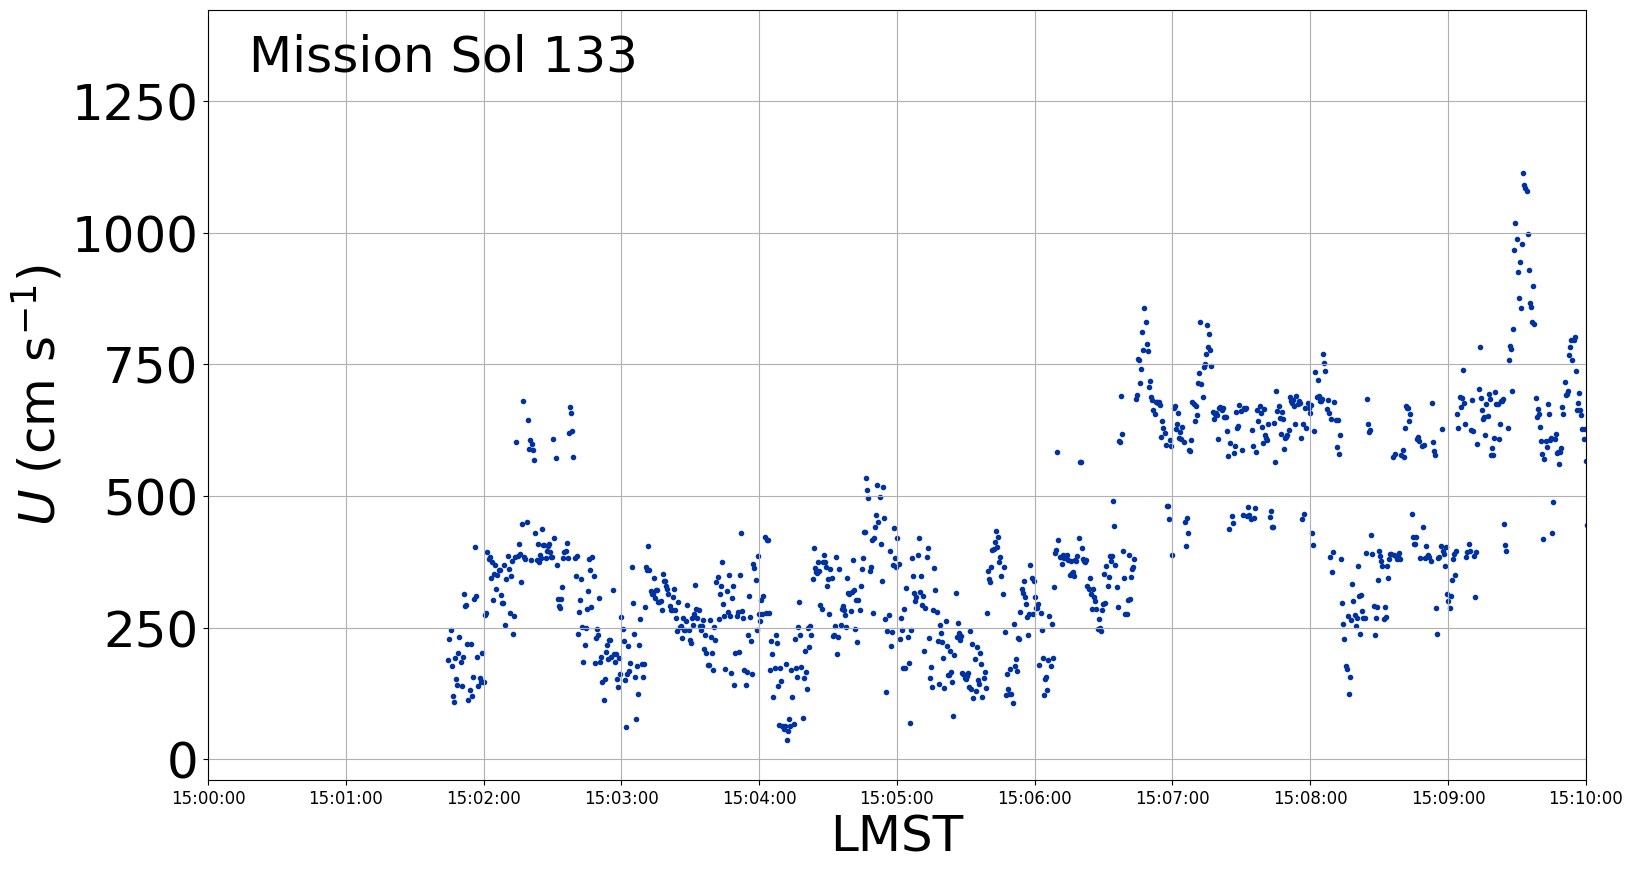

In [3]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

ax.text(0.03, 0.92, "Mission Sol 133", transform=ax.transAxes, fontsize=36)
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
ax.set_xlim([datetime(1900, 1, 1, 15, 0, 0), datetime(1900, 1, 1, 15, 10, 0)])

# Sure looks to me like there's a correlation timescale of about 30 seconds

0.9579007968104251


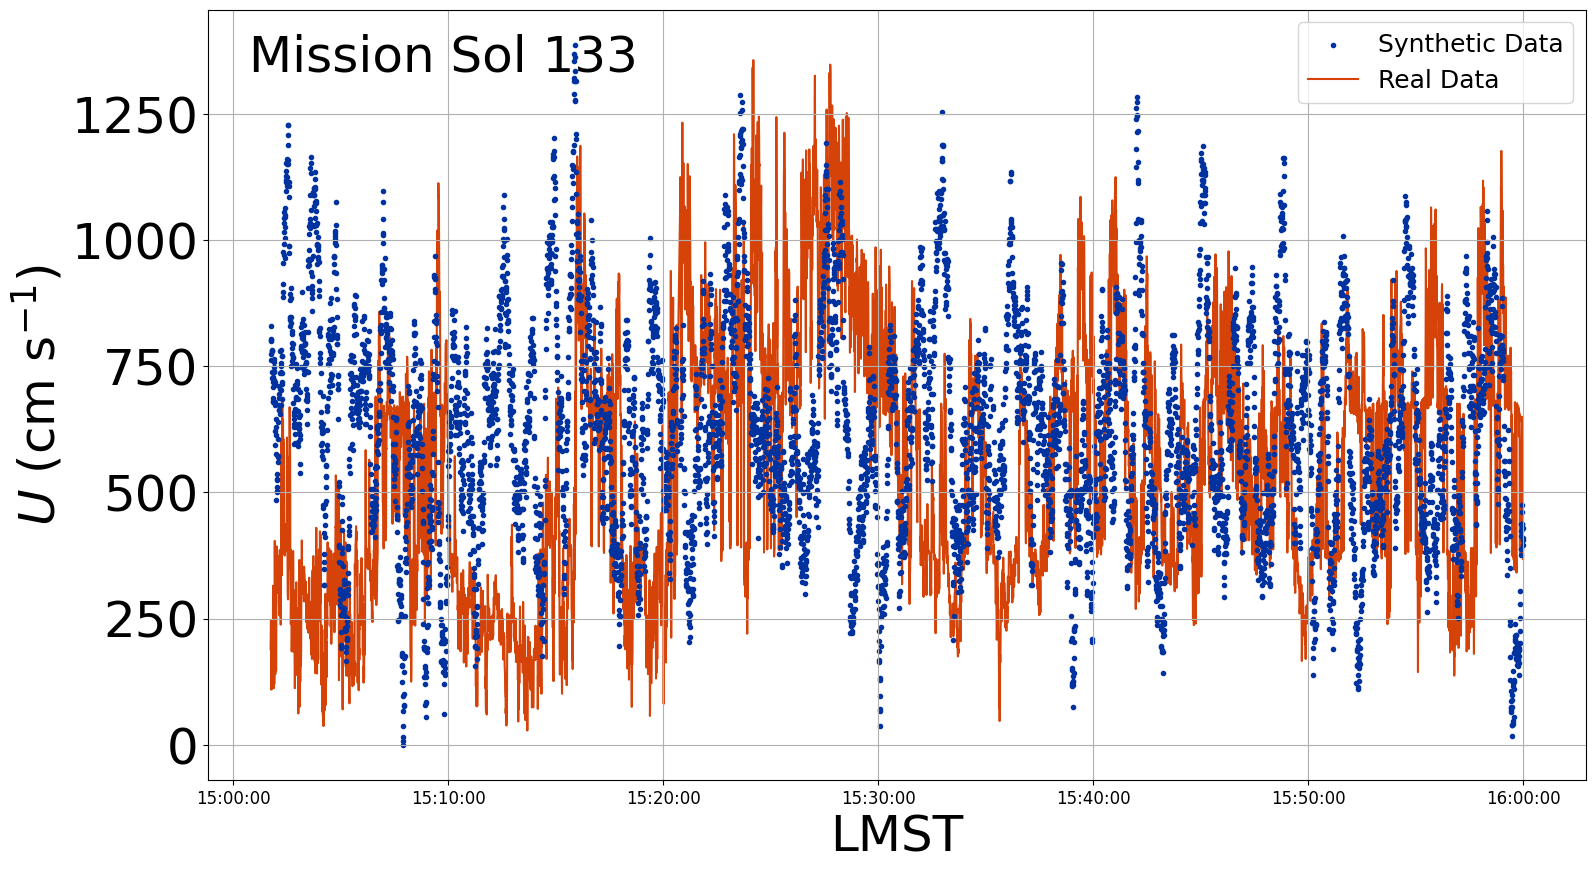

In [3]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.text(0.03, 0.92, "Mission Sol 133", transform=ax.transAxes, fontsize=36)

# Boxcar filter to inject red noise
synthetic_wind = generate_synthetic_wind(time, wind)

print((np.max(wind) - np.min(wind))/(np.max(synthetic_wind) - np.min(synthetic_wind)))

# synthetic_wind = uniform(size=len(time), low=np.min(wind), high=np.max(wind))
# synthetic_wind = np.median(wind) + medfilt(normal(size=len(time), scale=mad(wind)), kernel_size=num_points)

ax.scatter(time, synthetic_wind, marker='.', color=BoiseState_blue, label="Synthetic Data")
ax.plot(time, wind, color=BoiseState_orange, zorder=-1, label="Real Data")
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
ax.legend(loc='best', fontsize=18)

fig.savefig("Comparing_Real_and_Synthetic_Data.png", dpi=300, bbox_inches="tight")

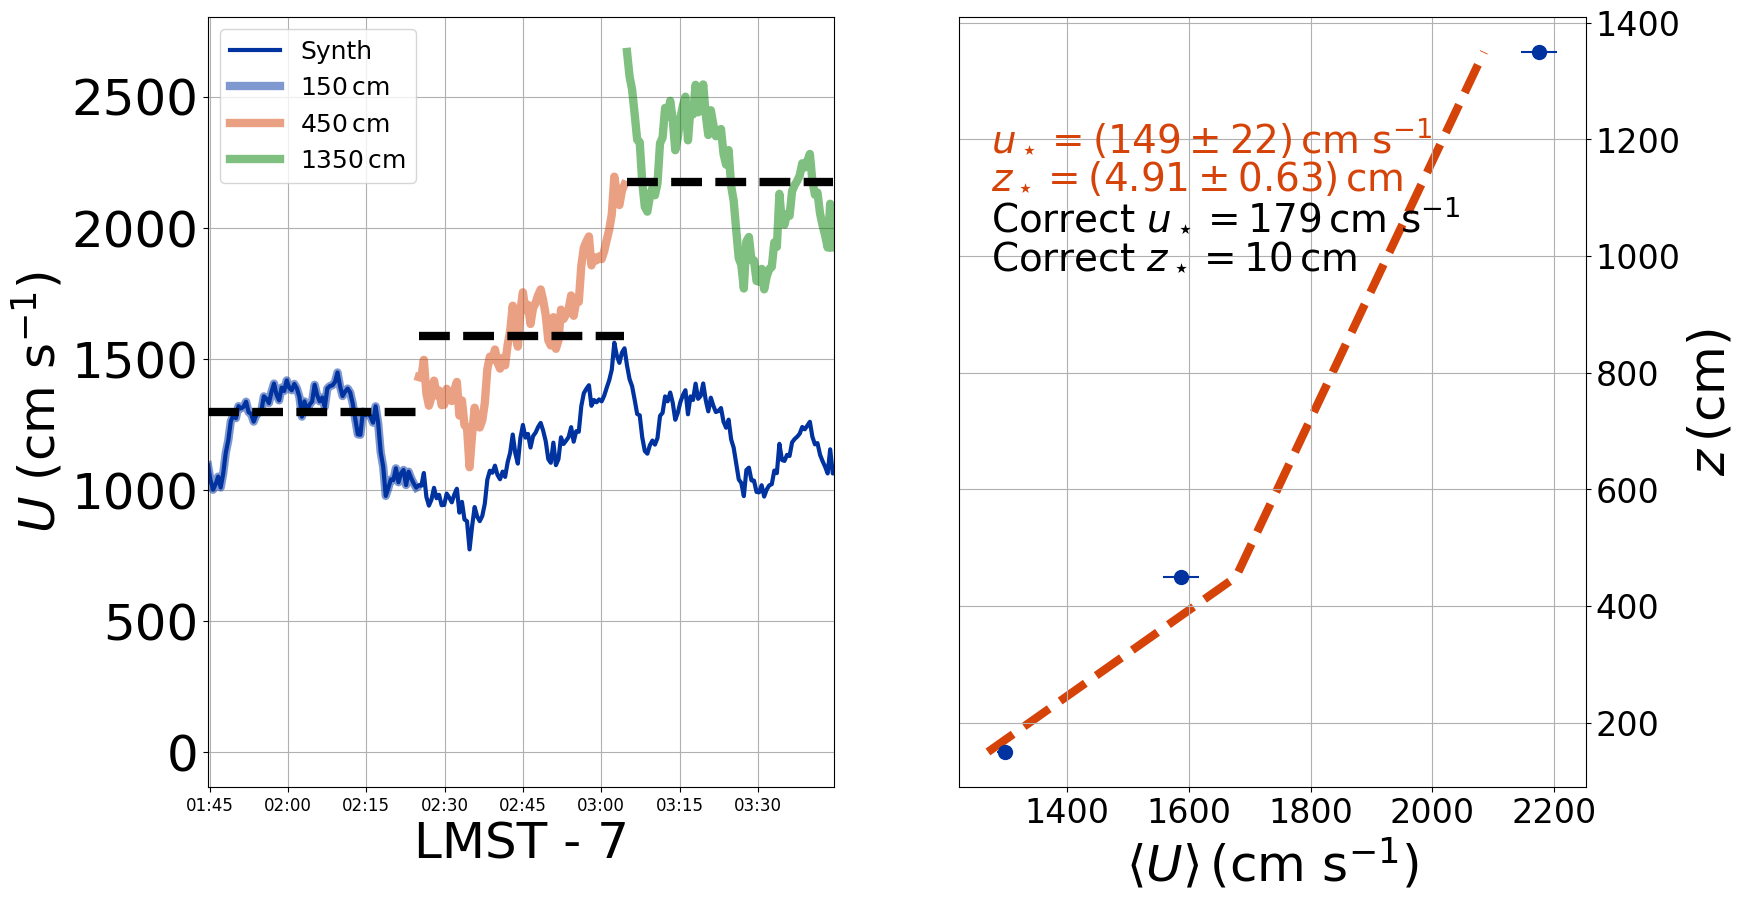

In [19]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

synthetic_wind = generate_synthetic_wind(time, wind)

saved_zstar = 10. # cm
t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)
saved_ustar = kappa*np.median(synthetic_wind[ind])/np.log(zs[0]/saved_zstar)

scaled_windspeeds = create_synthetic_wind_profile(synthetic_wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
ax1 = make_plot_of_original_and_scaled_windspeeds(time, synthetic_wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1, label="Synth")

u_star, z_star, sigma_u_star, sigma_z_star, std_windspeeds =\
    fit_wind_profile_scaled_values(zs, averaged_windspeeds, std_windspeeds, rescale_unc=False)

ax2 = make_plot_of_wind_data_and_profile_scaled_values(zs, averaged_windspeeds, 
    std_windspeeds, u_star, z_star, sigma_u_star, sigma_z_star, ax2)

ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)
ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
         fontsize=28, transform=ax2.transAxes)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])

fig.savefig("Fitting_Wind_Profile_to_Synthetic_Data.png", dpi=300, bbox_inches="tight")